## Abstract
In this blog post, a Machine Learning Model is trained, using the American Community's Public Use Microdata Sample data, to predict employment status of individuals using features other than race. A bias audit is then performed to evaluate if the model exhibits racial bias. In our bias audit, we prove that proxies are leading to individuals from specific racial categories being treated very differently with regards to error rate balance and calibration. This, and the implications with regards to our model, are discussed further in the final discussion.

## Descriptive Analysis

## Loading the Data

Download the data from the PUMAs fataset for the survey from 2018, at the individual level, and for the state of California.

In [167]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import pandas as pd
import numpy as np

STATE = "CA"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000004,9,1,3701,4,6,1013097,32,30,...,34,60,60,7,8,59,33,8,58,32
1,P,2018GQ0000013,9,1,7306,4,6,1013097,45,18,...,0,0,0,91,46,46,0,89,45,0
2,P,2018GQ0000016,9,1,3755,4,6,1013097,109,69,...,105,232,226,110,114,217,2,111,2,106
3,P,2018GQ0000020,9,1,7319,4,6,1013097,34,25,...,67,0,34,34,69,0,34,35,0,0
4,P,2018GQ0000027,9,1,6511,4,6,1013097,46,31,...,47,81,10,11,79,47,44,81,47,10


Let's limit the scope of features which are relevant to our problem: 

In [168]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,30,14.0,1,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,8,6.0
1,18,14.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0
2,69,17.0,1,17,1,NaN,1,1.0,2.0,2,1,2,2,2.0,1,9,6.0
3,25,1.0,5,17,1,NaN,1,1.0,4.0,1,1,1,2,1.0,1,1,6.0
4,31,18.0,5,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0


RAC1P is our data variable for race, and so that should be excluded from our set of predictor variables. ESR is our target variable for employment status. Let's make a subset of features excluding these:

In [169]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

Now we can construct a BasicProblem around our dataset and these different sets of features we have created.

In [170]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

In [171]:
for obj in [features, label, group]:
  print(obj.shape)

(378817, 15)
(378817,)
(378817,)


Now that we have set up our features, label, and group we should perform our train test split:

In [172]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

Let's look through the data in dataframe form:

In [173]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

In [174]:
df.shape

(303053, 17)

There are 303053 individuals who filled out the survey in California in the year of 2018.

How many of these individuals are employed?

In [175]:
df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,77.0,16.0,2.0,0.0,2.0,0.0,4.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1,True
1,29.0,20.0,5.0,2.0,2.0,0.0,3.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,6,True
2,60.0,21.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1,False
3,27.0,19.0,5.0,13.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,1,False
4,63.0,23.0,3.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False


In [176]:
df.groupby("label").size()

label
False    164678
True     138375
dtype: int64

There are 138,375 employed individuals in our data subset, and 164,678 unemployed individuals in our dataset.

In [177]:
df.groupby(["group", "label"]).size()

group  label
1      False    100725
       True      85639
2      False      8845
       True       5702
3      False      1371
       True        895
4      False        17
       True          7
5      False       410
       True        307
6      False     23987
       True      23493
7      False       517
       True        459
8      False     19069
       True      16227
9      False      9737
       True       5646
dtype: int64

The number of employed individuals who filled out the survey, based on racial category, are as follows:
White: 85,639
Black/African American: 5,702
American Indian: 895
Alaska Native: 7
American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races: 307
Asian: 23,493
Native Hawaiian and Other Pacific Islander: 459
Any other race alone: 16,227
Two or More Races: 5,646

In [178]:
true_group_prop = df.groupby("group")["label"].mean()
true_group_prop

group
1    0.459525
2    0.391971
3    0.394969
4    0.291667
5    0.428173
6    0.494798
7    0.470287
8    0.459740
9    0.367029
Name: label, dtype: float64

The ratio of employed individuals in each racial category are as follows:

White: 0.459525

Black/African American: 0.391971

American Indian: 0.394969

Alaska Native: 0.291667

American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races: 0.428173

Asian: 0.494798

Native Hawaiian and Other Pacific Islander: 0.470287

Any other race alone: 0.459740

Two or More Races: 0.367029

#### Intersectional Trends of Race, Gender, and Employment

Let's create a relational visualization of Employment based on Race and Gender:

In [179]:
import seaborn as sns
df_plot = df.groupby(["group", "SEX"])["label"].mean().reset_index()
df_plot["SEX"] = df_plot["SEX"].replace({1: "MALE", 2: "FEMALE"})


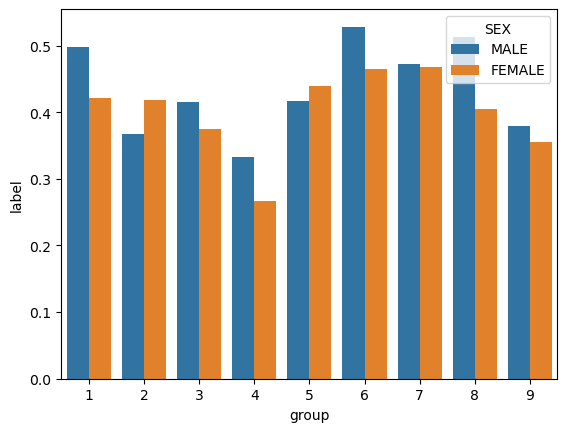

In [180]:
p1 = sns.barplot(df_plot, x = "group", y = "label", hue = "SEX")

While in most racial categories, Male employment rates (in our dataset) are higher than Female employment rates, there is a lot of variation. Other races, Asian, Alaskan Native, and White Male's have especially higher levels of employment compared to their Female counterparts. Female's outperform male's in the Black/African American categories and the "American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races" category. 

## Training the Model

In [181]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
max_depth_best = 1
CV_score_best = 0
for i in range(1, 20):
    model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=i))
    model.fit(X_train, y_train)
    cv_scores_RF = cross_val_score(model, X_train, y_train, cv=5)
    if cv_scores_RF.mean( ) > CV_score_best:
        max_depth_best = i
        CV_score_best = cv_scores_RF.mean()

print("Best Maximum Depth: ", max_depth_best)
print("Cross Validation Mean: ", CV_score_best)


Best Maximum Depth:  11
Cross Validation Mean:  0.8178074392200193


With the optimal maxiumum depth determined, let's train our model with it.

In [182]:

model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=max_depth_best))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=11))])

#### Cross Validation
Let's test our model using cross validation

In [183]:

from sklearn.model_selection import cross_val_score
cv_scores_RF = cross_val_score(model, X_train, y_train, cv=5)
cv_scores_RF

array([0.81858079, 0.81641946, 0.82059362, 0.81753836, 0.81598746])

Our highest level of cross validation is achieved with a max depth of 11 in our Decision Classifier Tree. Our cross validation is scoring between .816 and .820 on all divisions.

## Audit

### Overall Accuracy

Let's see how our accurate our model performs on the test data:

In [184]:
y_hat = model.predict(X_test)
df_audit = pd.DataFrame(X_test, columns = features_to_use)
df_audit["group"] = group_test
df_audit["label"] = y_test
df_audit["pred"] = y_hat

In [185]:

(y_hat == y_test).mean()

0.8179478380233356

Our overall testing accuracy is .818, which is in the same range as the values we observed in our cross validation. Knowing that our model is performing similar to how we expected based on the training data.

### Overall Positive Predictive Value 


Let's calculate the value of our PPV:

In [186]:
df_audit["correct"] = df_audit["label"] == df_audit["pred"]
df_audit.groupby("pred")["correct"].mean()

pred
False    0.872454
True     0.765990
Name: correct, dtype: float64

The model is more accurate at predicting unemployment than it is at predicting employment. Our positive predictive value (PPV) of .766 means that for all individuals predicted to be employed, the model was correct about that prediction 76.6% of the time. 



### Error Rate Balance


Now Let's calculate our overall error rate balance.

In [187]:
df_audit.groupby("label")["pred"].mean()

label
False    0.219591
True     0.863018
Name: pred, dtype: float64

This shows us that the model predicted 86.3% of the employed individuals to be employed. It was similarly accurate on the unempoloyed—21.8% of unemployed individuals were incorrectly predicted to be employed. Our False positive rate is therefor 21.8% and our false negative rate is 13.7%. 

### Group Level Audit

Let's see how the model performed when comparing performance on individuals of different races.

#### Accuracy

In [188]:
df_audit.groupby("group")["correct"].mean()

group
1    0.818315
2    0.819561
3    0.794918
4    0.750000
5    0.768750
6    0.808710
7    0.767241
8    0.815245
9    0.856801
Name: correct, dtype: float64

The two groups which include alaskan natives, and pacific islanders have significantly lower accuracy than the other groups as seen above. The group with the highest accuracy is that for individuals who identify as more than 1 race.

#### PPV — By group

Let's calculate the PPV again, but this time focussing on group level statistics.

In [189]:
sufficiency_group = df_audit.groupby(["pred", "group"])["correct"].mean().reset_index()
sufficiency_group

,pred,group,correct
0,False,1,0.867909
1,False,2,0.904935
2,False,3,0.910714
3,False,4,1.000000
4,False,5,0.789474
5,False,6,0.855907
6,False,7,0.859813
7,False,8,0.874412
8,False,9,0.927146
9,True,1,0.769823


The composite group for native north american's have a significantly lower accuracy for negatively predicted values at 79%. This means that the model is more likely to predict individuals who are unemployed as employed from this group. It is interesting to not that this group does not have a corresponding different Positive predictive value. Instead, Alaskan Natives have the lowest PPV at .667. This means that alaskan natives, who are predicted to be employed are only employed 66.67% of the time. For both the NPV and PPV, their is significant variation among groups. While it is not perfect, I would say that this model is not horribly calibrated, especially when compared to it's error rate balance below. 

### Error Rate Balance — By Group

In [190]:
df_audit.groupby(["label", "group"])["pred"].mean()


label  group
False  1        0.213360
       2        0.217079
       3        0.256560
       4        0.500000
       5        0.259259
       6        0.255563
       7        0.297710
       8        0.231342
       9        0.160504
True   1        0.856327
       2        0.875171
       3        0.879808
       4        1.000000
       5        0.797468
       6        0.873556
       7        0.851485
       8        0.870073
       9        0.886561
Name: pred, dtype: float64

The False FPR and TPRs shown above demonstrate that once again our model is treating different groups very differently. The range for FPR are from .16 for individuals of 2 or more races up to .5 for Alaskan Natives. Our model is very likely to predict Alaskan Native's as being employed, with 100% of employed individuals accurately predicted and 50% of unemployed individuals predicted as employed as well. Most other race categories are in similar ranges of .21 - .26 for FPV and .86-.88 for TPV values. The group with the lowest FPR are those from 2 or more races with a FPR of .16 and a TPR of .89. Similarly with the PPVs, the group 5, for individuals from Alaskan Native or American Indian tribes not specified, the TPR is the lowest of all the groups at .797. Based on these numbers it is clear that our model is not quite calibrated. Certain groups clearly have been scrutinized much more by the data, and it is hard to predict what the negative consequences of a model like this that is not well calibrated might be. Particularly, the treatment of the group 5 worries me, as that group and Alaskan Natives are consistently treated differently from the other groups in terms of Error Rate Balance and PPV. While Black and White groups are balanced quite well, it is concerning to me that other, likely smaller and even more disadvantaged groups are not similarly balanced. 

### Statistical Parity

Let's see how race influences the chances of being categorized as employed:

In [191]:
df_audit.groupby("group")["pred"].mean().reset_index()

,group,pred
0,1,0.505611
1,2,0.478461
2,3,0.491833
3,4,0.750000
4,5,0.525000
5,6,0.563188
6,7,0.538793
7,8,0.524757
8,9,0.427471


Our data shows that the model does not reach statistical parity. The range of predicted proportions of employed individuals across groups range from .75 to .427. While we have not proven that this is statistically significant, the difference is large enough that I highly doubt it would not be.

### Figure

Let's make a figure to explore the FPR and FNR.

First lets make a function to get the rates by group and store them.

In [192]:
def get_rates(group):
    FP = sum((group["pred"] == 1) & (group["label"] == 0))
    FN = sum((group["pred"] == 0) & (group["label"] == 1))
    TN = sum((group["pred"] == 0) & (group["label"] == 0))
    TP = sum((group["pred"] == 1) & (group["label"] == 1))
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0
    return pd.Series({"FPR": FPR, "FNR": FNR})

Now lets pass in the data to get the rates for each group, and lets make a color palette for our visualization.

In [193]:
rates = df_audit.groupby("group").apply(get_rates).reset_index()
rates






,group,FPR,FNR
0,1,0.213360,0.143673
1,2,0.217079,0.124829
2,3,0.256560,0.120192
3,4,0.500000,0.000000
4,5,0.259259,0.202532
5,6,0.255563,0.126444
6,7,0.297710,0.148515
7,8,0.231342,0.129927
8,9,0.160504,0.113439


We will use the PPV of 0.666667, as it falls close to the middle of the existing values of our model for all groups. We can calculate each groups prevalence of employment by taking the mean of the label group.

Now we can pass the data to a plot to create our visualization. This plot will include a scatter plot of the observed values, and lines showing the theoretical values. 

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

PPV = 0.666667
p = df_audit.groupby("group")["label"].mean().reset_index()
def calc_FPR(FNR, PPV, prev):
    return ((prev)/(1-prev))*((1-PPV)/(PPV))*(1-FNR)

df_list = []
for i, row in p.iterrows():
    FNR_vals = np.linspace(0, 1, 100)
    FPR_vals = calc_FPR(FNR_vals, PPV, row["label"])
    df_FC = pd.DataFrame({"FNR": FNR_vals, "FPR": FPR_vals, "group": row["group"]})
    df_list.append(df_FC)

df_FC = pd.concat(df_list)
df_FC










,FNR,FPR,group
0,0.000000,0.416650,1.0
1,0.010101,0.412441,1.0
2,0.020202,0.408232,1.0
3,0.030303,0.404024,1.0
4,0.040404,0.399815,1.0
...,...,...,...
95,0.959596,0.011748,9.0
96,0.969697,0.008811,9.0
97,0.979798,0.005874,9.0
98,0.989899,0.002937,9.0


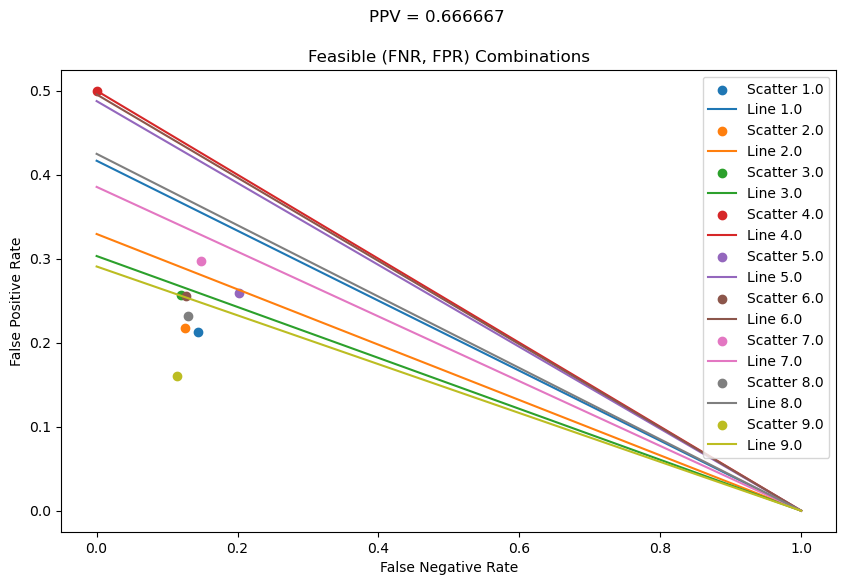

In [199]:
palette = [
    "#1f77b4",  # Muted blue
    "#ff7f0e",  # Safety orange
    "#2ca02c",  # Cooked asparagus green
    "#d62728",  # Brick red
    "#9467bd",  # Muted purple
    "#8c564b",  # Chestnut brown
    "#e377c2",  # Raspberry yogurt pink
    "#7f7f7f",  # Middle gray
    "#bcbd22"   # Curry yellow-green
]

group_colors = {group: color for group, color in zip(df_FC['group'].unique(), palette)}

fig, ax = plt.subplots(1,1,figsize=(10, 6))
for group, color in group_colors.items():
    df_group = df_FC[df_FC['group'] == group]
    df_rates = rates[rates['group'] == group]
    ax.scatter(x=df_rates["FNR"],y =df_rates["FPR"],  color=color, label=f"Scatter {group}")
    ax.plot(df_group["FNR"], df_group["FPR"],color=color, label=f"Line {group}")

plt.ylabel("False Positive Rate")
plt.xlabel("False Negative Rate")
plt.title("Feasible (FNR, FPR) Combinations")
plt.suptitle("PPV = 0.666667")
plt.legend()

plt.show()


In order, for example, to make our FPR for Native Hawaiian or Pacific Islander (group 7) to match our FPR for white individuals (group 1), we would need to increase the false negative rate for group 7 to about 4.5. This would significantly reduce our accuracy, and would not necessarily be beneficial for either group involved. 

## Discussion

1) What groups of people could stand to benefit from a system that is able to predict the label you predicted, such as income or employment status? For example, what kinds of companies might want to buy your model for commercial use?
2) Based on your bias audit, what could be the impact of deploying your model for large-scale prediction in commercial or governmental settings?
3) Based on your bias audit, do you feel that your model displays problematic bias? What kind (calibration, error rate, etc)?
4) Beyond bias, are there other potential problems associated with deploying your model that make you uncomfortable? How would you propose addressing some of these problems?

The government might be interested in a model for predicting employment status in order to deliver aid to communities most in need. On the other hand, any commercial entity that requires economic trust in an individual(credit card companies, banks, land loards) might find it beneficial to be able to predict the employment status of individuals if they cannot sift through all applications they are receiving for their service. 

Our model would result in significant disparities in the ways in which different groups are treated. Most interestingly, the Alaskan Native population had a FPR of .5 and a FNR of 0. While such a low FNR might seem great, the tradeoff is that individuals are quite often being identified as employed when they are in-fact not. Even this seemingly beneficial categorization could have a very negative implication for the individual such as not receiving necessary aid, or being given a loan they cannot afford. 

My model exhibits significant Error Rate balance issues, such as the one mentioned in the paragraph above. It is especially concerning to me how differently the various groups are being treated in this category, with FPR ranging from 0 to 21% and FNR ranging from 50 to 16%. Its error rate balance, while still exhibiting some levels of bias is much less concerning than the error rate balance. 

I generally do not feel comfortable deploying models that have to do with classifying individuals. I believe especially strongly about this when it comes to government use of these models. If governments are supposed to treat individuals equally, it makes no sense to allow them to treat you differently based on similarities between group categorizations. I think individuals deserve to be reviewed as an individual.